In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

from matplotlib.patches import Rectangle

## Test integrating equations of motion for broken power law

The Chevalier solutions assume a power law CSM and ejecta.


Initial condition: radius (r_s), velocity (v_s) at time (t).
Then in this order for a given time step delta_t:
* determine new Rs at t+delta_t based on velocity v_s at time t.
* based on new Rs, determine new parameters needed for equation of motion: Mej,Mcsm,rho_ej,rho_CSM,V
* with those new 'constants' solve the equation of motion for Vs using a RK4 scheme.

Note that if I'm just varying the CSM, and not the ejecta power law (suspect) I can just use the analytic solutions of Chev/Frannson. Perhaps use those to set the initial conditions. If I am varying both, I can still use these to set the initial conditions, I just need to determine the radius Rs at which the reverse shock has transitioned through the outer portion of the ejecta.

I will need to:
1) Set an ejecta density profile. This reduces to the rho_0, t_0, V_0 combination? i.e. the density of a particular velocity element at a certain time post-explosion. I could make this a broken power law by defining these at velocity where the power law breaks. Chevalier and Fransson 94 (https://articles.adsabs.harvard.edu/pdf/1994ApJ...420..268C) gives equations for this. 

2) Set the CSM density profile. I will treat as 2-3 power laws. (3 if I want to mimic a rapid fall from a shell and then wind-like outside of that.)

What this will give me:
* the radius and the velocity of the interaction region as a function of time. From this I can calculate the density at both shock fronts as well as the total swept up mass by both shocks at the time of our X-ray observation.
* The final piece I need to calculate the X-ray luminosity, in the adiabatic case, is then the shock temperature. Poonam refers to the 'strong shock limit'.
 * From Here: https://www.astro.rug.nl/~weygaert/tim1publication/astrohydro2014/achterberg.ngsa.shockwaves.pdf This should just depend on the density at the shock (upstream) and the velocity of the shock. The velocity of the forward shock is Vs and the velocity of the reverse shock is V-Vs.
 * Not sure how this relates to the temperatures Chevalier gives for equipartian. Try checking?

#### Try performing an initial test where the CSM and ejecta profiles are single power laws:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#Ejecta profile:
def ejecta_scale_c94(delta=2,n=12,E=1e51,M=10,time=1):
    '''This will calculate the transition velocity and the scaling
    
    delta: power-law scaling for inner part of ejecta (<3)
    n: power-law scaling for outer part of ejecta (>5)
    E: energy of explosion in ergs
    M: ejecta mass in solar masses
    time: time to use for the scaling, in years.'''

    #calculate the transition velocity:
    msun = 1.989e+33 #grams
    v_transition_numerator = 2*(5-delta)*(n-5)*E
    v_transition_demoninator = (3-delta)*(n-3)*M*msun
    v_transition = np.sqrt(v_transition_numerator/v_transition_demoninator) #cm/s
    v_transition_kms = v_transition / 1e5
    
    #calculate the density at the transition velocity and the time used as input
    #this can then be used as the v0,t0,rho0 for either part of the broken powerlaw
    s_in_year = 3.154e+7
    time_s = time * s_in_year
    radius = time_s * v_transition # this is in cm
    rho_sn = (1/(4*np.pi*(n-delta)))*v_transition_numerator**((n-3)/2)/v_transition_demoninator**((n-5)/2)*time_s**(-3)*(radius/time_s)**(-n)

    return v_transition,rho_sn,time_s

#CSM profile:


#Initial Considtions
def initial_conds_f96(time_calc,delta=2,n=12,E=1e51,M=10,t0=1,Mdot=1e-3,vw=100,r0=1e15,s=1.5):
    '''This will give us a set of initial conditions: v_s, r_s, t_s based on the solution for Fransson96
    This will be the starting point for our integration.
    
    time_calc: times when we want Rs and v_s based on these solutions. In years
    
    delta: power-law scaling for inner part of ejecta (<3)
    n: power-law scaling for outer part of ejecta (>5)
    E: energy of explosion in ergs
    M: ejecta mass in solar masses
    t0: time to use for the scaling of the ejecta density profile, in years.
    
    Mdot: solar masses per year
    vw: wind velocity in km/s
    r0: reference radius in cm
    s: power-law profile for initial part of CSM.
    '''
    
    #Get scaling for the ejectr profile:
    v0,rho0,t0 = ejecta_scale_c94(delta=delta,n=n,E=E,M=M,time=t0)
    
    #Fix units on the CSM profile:
    msun = 1.989e+33 #grams
    s_in_year = 3.154e+7
    Mdot_g_s = Mdot*msun/s_in_year
    vw_cm = vw*1e5
    
    #Decide to just have the initial conditions defined at the same time:
    time_s = time_calc * s_in_year
    
    #Radius based on eqn 2.2 (NB: have multiplied by t to get Rs as opposed to V)
    Rs_numerator = 4*np.pi * (3-s) * (4-s) * rho0 * t0**3 * v0**n * vw_cm * r0**(2-s)
    Rs_demoninator = (n-3) * (n-4) * Mdot_g_s
    Rs = (Rs_numerator/Rs_demoninator)**(1/(n-s)) * time_s**((n-3)/(n-s))
    Vs = (Rs_numerator/Rs_demoninator)**(1/(n-s)) * ((n-3)/(n-s)) * time_s**((s-3)/(n-s))
    
    return Rs,Vs,time_s

#Params based on a new Rs
def physical_params_rs_v1(Rs,time_calc,delta=2,n=12,E=1e51,M=10,t0=1,Mdot=1e-3,vw=100,r0=1e15,s=1.5):
    '''This will go through and calculate Mej,Mcsm,rho_ej,rho_CSM,V for a given Rs.
    In this version (v1) it will do so just assuming a single power law for the CSM and for the ejecta.
    See later versions where that is relaxed.
    
    Rs: shock radius in cm
    time_calc: time when this will be caluclated in years.
    
    delta: power-law scaling for inner part of ejecta (<3)
    n: power-law scaling for outer part of ejecta (>5)
    E: energy of explosion in ergs
    M: ejecta mass in solar masses
    t0: time to use for the scaling of the ejecta density profile, in years.
    
    Mdot: solar masses per year
    vw: wind velocity in km/s
    r0: reference radius in cm
    s: power-law profile for initial part of CSM.
    '''
    
    #Swept up circumstellar mass:
    msun = 1.989e+33 #grams
    s_in_year = 3.154e+7
    Mdot_g_s = Mdot*msun/s_in_year
    vw_cm = vw*1e5
    M_csm = Mdot_g_s*Rs/((3-s)*vw_cm) * (Rs/r0)**(2-s)

    #Swept up ejecta:
    v0,rho0,t0 = ejecta_scale_c94(delta=delta,n=n,E=E,M=M,time=t0)
    time_s = time_calc * s_in_year
    M_ej = (4 * np.pi * rho0 * v0**n * t0**3)/(n-3) * (time_s/Rs)**(n-3)
    
    #rho_csm
    rho_csm = Mdot_g_s / (4 * np.pi * r0**2 * vw_cm) * (r0/Rs)**s
    
    #rho_ej
    rho_ej = rho0 * v0**n * t0**3 * time_s**(n-3) * Rs**(-n)
    
    #V = Rs/t
    V = Rs/time_s
    
    return M_csm, M_ej, rho_csm, rho_ej, V

#Params based on a new Rs
def physical_params_rs_v2(Rs,time_calc,delta=2,n=12,E=1e51,M=10,t0=1,Mdot1=1e-3,Mdot2=1e-5,vw=100,r0=1e15,s1=1.5,s2=20,s3=2):
    '''This will go through and calculate Mej,Mcsm,rho_ej,rho_CSM,V for a given Rs.
    In this version (v2) it will do so assuming:
    *broken power law for ejecta. Described by two power-law slopes, with a transition velocity between the two.
    *double broken power law for CSM: shallow, v. steep, shallow. This mimics the idea of a shell surrounded by a lower-density medium
    
    Rs: shock radius in cm
    time_calc: time when this will be caluclated in years.
    
    delta: power-law scaling for inner part of ejecta (<3)
    n_o: power-law scaling for outer part of ejecta (>5)
    E: energy of explosion in ergs
    M: ejecta mass in solar masses
    t0: time to use for the scaling of the ejecta density profile, in years.
    
    Mdot1: solar masses per year for inner shell
    Mdot2: solar masses per year for outer shell (should be less than Mdot1 as defined)
    vw: wind velocity in km/s
    r0: reference radius in cm; also serves as edge of dense shell
    s1: power-law profile for initial part of CSM.
    s2: power-law for steep transition
    s3: power-law for outer part of CSM
    '''
    
    #Circumstellar Material:
    msun = 1.989e+33 #grams
    s_in_year = 3.154e+7
    Mdot1_g_s = Mdot1*msun/s_in_year
    Mdot2_g_s = Mdot2*msun/s_in_year
    vw_cm = vw*1e5
    
    #use power laws to find second transition radius:
    r2 = (Mdot1/Mdot2)**(1/(s2-s3)) * r0 
    if Rs < r0:
        rho_csm = Mdot1_g_s / (4 * np.pi * r0**2 * vw_cm) * (r0/Rs)**s1
        M_csm = Mdot1_g_s*Rs/((3-s1)*vw_cm) * (Rs/r0)**(2-s1)
        #print('r1','Rs',Rs,'rho_csm',rho_csm,'Mcsm',M_csm/msun)
    elif Rs < r2:
        #on the steep transition:
        rho_csm = Mdot1_g_s / (4 * np.pi * r0**2 * vw_cm) * (r0/Rs)**s2
        M_csm_term1 =  Mdot1_g_s * r0/((3-s1)*vw_cm) 
        M_csm_term2 = Mdot1_g_s * r0**(s2-2)/((3-s2)*vw_cm)*(Rs**(3-s2)-r0**(3-s2)) 
        M_csm = M_csm_term1 + M_csm_term2
        #print('r2',r2,'Rs',Rs,'rho_csm',rho_csm,'term1,2',M_csm_term1,M_csm_term2,'Mcsm',M_csm)
        #print('r2','Rs',Rs,'rho_csm',rho_csm,'Mcsm',M_csm/msun)
    else:
        #on the outer bit:
        rho_csm = Mdot2_g_s / (4 * np.pi * r0**2 * vw_cm) * (r0/Rs)**s3
        M_csm_term1 =  Mdot1_g_s * r0/((3-s1)*vw_cm)  
        M_csm_term2 = Mdot1_g_s * r0**(s2-2)/((3-s2)*vw_cm)*(r2**(3-s2)-r0**(3-s2)) 
        M_csm_term3 = Mdot2_g_s * r0**(s3-2)/((3-s3)*vw_cm)*(Rs**(3-s3)-r2**(3-s3))
        M_csm = M_csm_term1 + M_csm_term2 + M_csm_term3

    
    
    #Ejecta:
    v0,rho0,t0 = ejecta_scale_c94(delta=delta,n=n,E=E,M=M,time=t0)
    time_s = time_calc * s_in_year
    rho_ej = rho0 * v0**n * t0**3 * time_s**(n-3) * Rs**(-n)
    M_ej = (4 * np.pi * rho0 * v0**n * t0**3)/(n-3) * (time_s/Rs)**(n-3)
    #if (Rs/time_s) > v0:
    #    rho_ej = rho0 * v0**n * t0**3 * time_s**(n-3) * Rs**(-n)
    #    M_ej = (4 * np.pi * rho0 * v0**n * t0**3)/(n-3) * (time_s/Rs)**(n-3)
    #else:
    #    rho_ej = rho0 * v0**delta * t0**3 * time_s**(delta-3) * Rs**(-delta)
    #    Mej_t1 = v0**3/(n - 3)
    #    Mej_t2 = v0**3/(delta - 3)
    #    Mej_t3 = v0**delta/(delta-3) * (time_s/Rs)**(delta-3)
    #    M_ej = 4 * np.pi * rho0 * t0**3 * (Mej_t1 - Mej_t2 + Mej_t3)
        
    
    
    #V = Rs/t
    V = Rs/time_s
    
    return M_csm, M_ej, rho_csm, rho_ej, V


def eom_c03(t,vs,Rs,M_csm,M_ej,rho_csm,rho_ej):
    '''This just calculates the right hand side of the equation of motion from Chevalier 2003 for some set of 
    variables. Everything should be in cgs units
    
    t: time 
    vs: shock velocity 
    Rs: shock radius for current time step
    M_csm: csm mass swept up 
    M_ej: ejecta mass swept up 
    rho_csm: density at cs shock 
    rho_ej: density at reverse shock 
    
    '''
    
    dVdt = 4*np.pi*Rs**2/(M_csm+M_ej) * (rho_ej * (Rs/t - vs)**2 - rho_csm*vs**2)
    
    #print('v1: ',Rs/t,'diff:',(Rs/t - vs),'v2: ',vs)
    #print('rho_ej: ',rho_ej,'rho_cs: ',rho_csm)
    #print(dVdt)
    
    return dVdt

def RK4_eom_c03(t_i,vs_i,step,Rs,M_csm,M_ej,rho_csm,rho_ej):
    '''This will do RK4 on the equation of motion from Chevleir 2003 in order to advance it a time step
    
    Everything should be input in cgs units
    
    t_i: time from previous time step
    vs_i: shock velocity from previous time step
    step: time step that we are taking
    
    Rs: shock radius for current time step
    M_csm: csm mass swept up (current)
    M_ej: ejecta mass swept up (current)
    rho_csm: density at cs shock (current)
    rho_ej: density at reverse shock (current)
    '''
    
    k1 = step * eom_c03(t_i,vs_i,Rs,M_csm,M_ej,rho_csm,rho_ej)
    #print('k1:',k1/1e5)
    
    t2 = t_i + step/2.
    v2 = vs_i + k1/2.
    k2 = step * eom_c03(t2,v2,Rs,M_csm,M_ej,rho_csm,rho_ej)
    
    t3 = t_i + step/2.
    v3 = vs_i + k2/2.
    k3 = step * eom_c03(t3,v3,Rs,M_csm,M_ej,rho_csm,rho_ej)
    
    t4 = t_i + step
    v4 = vs_i + k3
    k4 = step * eom_c03(t4,v4,Rs,M_csm,M_ej,rho_csm,rho_ej)
    
    vs_new = vs_i + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
    
    return vs_new

def shock_temp(Vs,V,gamma=5/3,mu = 0.63):
    '''This will calculate the temperature at both the forward and reverse shock, in the strong shock limit.
    Vs = dRs/dt, shock speed
    V = Rs/t, speed of ejecta at reverse shock.
    
    gamma = 5/3 for an ideal gas
    mu: mean mass per particle. for solar abundance mu=0.63, for n(H)/n(He) =1 mu =1'''
    
    #define some constants:
    mh = 1.6733e-24 #g
    k = 1.380658e-16 # erg/K
    
    #prefactor: 
    const = 2*(gamma-1)*mu*mh/((gamma+1)**2 * k)
    
    #forward shock:
    T_fs = const * Vs**2
    
    #reverse shock:
    T_rs = const * (V - Vs)**2
    
    return T_fs, T_rs

def adiabatic_lum(Mk,rhok,Te,gff='N06',xi=0.86,Ncds=0,Ncsm=0,Ngal=0,int_low=0.3,int_high=10):
    '''This calculates the adiabatic luminosity using the expression from the various Chev and Fransson papers. 
    
    Mk: swept up mass of the component you care about (can be an array).
    rhok: densiity at the shock you care about (can be an array)
    Te: electron temp at shock (can be an array)
    gff: the gaunt factor. Allwed are N06 (Nymark+06), F96r (Franssn 96 for rev. shock at 1kev) or F96f (Fransson 96 for forward shock at 1kev)
    xi: composition dependent. solar=0.86
    Ncds = any column density from the cold dense shell (above reverse shock) to apply
    Ncsm = any column density from the CSM outside the forward shock to apply
    Ngal = any Milky Way column density to apply.
    int_low: low end of integration (keV)
    int_high: high end of integration (keV)
    
    '''
    #constants:
    mh = 1.6733e-24 #g
    #k = 1.380658e-16 # erg/K
    k = 8.617333262145e-8 #kev/K
    
    #energy array that we will integrate over (keV)
    energy_int = np.linspace(int_low,int_high,num=100)
    
    #make sure everything is a numpy array:
    Mk = np.array(Mk)
    rhok = np.array(rhok)
    Te = np.array(Te)
    
    #define gaunt factor if not entered as a number:
    if gff=='N06':
        gff=2.3 * (Te/1e9)**0.42 * (12.4/energy_int)**0.23
    if gff=='F96r':
        gff=1.87 * (Te/1e8)**0.264
    if gff=='F96f':
        gff=3.45 * (Te/1e9)**0.663
    
    #Cycle over the input arrays:
    Lk = np.zeros(len(Mk))
    for i in range(len(Mk)):
        
        #Define the jff factor (this should have one unit per energy step):
        jff = 1.64e-20 * xi * gff[i] * Te[i]**(-0.5) * np.exp(-energy_int/(k*Te[i])) # egs/cm^3/s/keV
        
        #This is per keV and has one step per energy.
        Lk_E = jff * Mk[i] * rhok[i] / mh**2
        
        #Do the absorption if needed (if they are zero it will return input array):
        Lk_E_v2 = nh_cor_wis(energy_int,Lk_E,Ncds)
        Lk_E_v3 = nh_cor_wis(energy_int,Lk_E_v2,Ncsm)
        Lk_E_v4 = nh_cor_wis(energy_int,Lk_E_v3,Ngal)
        
        #Integrate this: 
        Lk[i] = np.trapz(Lk_E_v4,energy_int)
    
    return Lk




def nh_cor_wis(energy,flux,nh):
    '''This corrects for absorption, based on the wisconsin crossections
    https://ui.adsabs.harvard.edu/abs/1983ApJ...270..119M/abstract
    see also:
    https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node267.html
    
    energy: energies of the SED. should be in keV
    flux: the spectrum to be corrected. either flux or lum is ok, should be in units of per keV.
    nh: neutral H column density. atoms/cm^2
    '''
    
    flux_cor = np.zeros(len(flux))
    
    for i in range(len(flux)):
        #Determine the proper coefficients for the cross section per H atom (from paper above)
        if (energy[i] > 0.03) and (energy[i] < 0.1):
            c0 = 17.2; c1=608.1; c2=-2150.
        elif (energy[i] >= 0.100) and (energy[i] < 0.284):
            c0 = 34.6; c1=267.9; c2=-476.1
        elif (energy[i] >= 0.284) and (energy[i] < 0.400):
            c0 = 78.1; c1=18.8; c2=4.3
        elif (energy[i] >= 0.400) and (energy[i] < 0.532):
            c0 = 71.4; c1=66.8; c2=-51.4
        elif (energy[i] >= 0.532) and (energy[i] < 0.707):
            c0 = 95.5; c1=145.8; c2=-61.1
        elif (energy[i] >= 0.707) and (energy[i] < 0.867):
            c0 = 308.9; c1=-380.6; c2=294.0
        elif (energy[i] >= 0.867) and (energy[i] < 1.303):
            c0 = 120.6; c1=169.3; c2=-47.7
        elif (energy[i] >= 1.303) and (energy[i] < 1.840):
            c0 = 141.3; c1=146.8; c2=-31.5
        elif (energy[i] >= 1.840) and (energy[i] < 2.471):
            c0 = 202.7; c1=104.7; c2=-17.0
        elif (energy[i] >= 2.471) and (energy[i] < 3.210):
            c0 = 342.7; c1=18.7; c2=0.0
        elif (energy[i] >= 3.210) and (energy[i] < 4.038):
            c0 = 352.2; c1=18.7; c2=0.0
        elif (energy[i] >= 4.038) and (energy[i] < 7.111):
            c0 = 433.9; c1=-2.4; c2=0.75
        elif (energy[i] >= 7.111) and (energy[i] < 8.331):
            c0 = 629.0; c1=30.9; c2=0.0
        elif (energy[i] >= 8.331) and (energy[i] <= 10.000):
            c0 = 701.2; c1=25.2; c2=0.0
            
        sigma = ((c0+c1*energy[i]+c2*energy[i]**2)/energy[i]**3)*1e-24 #unit = cm^2/atom
        me = np.exp(-nh*sigma)
        flux_cor[i] = flux[i]*me
        
    
    return flux_cor


def tcool_N09(T,rho,td,comp='solar'):
    '''This uses the expression from Nymark+06 for cooling time (eqn 37)
    
    T = temperature at the shock (K)
    rho = density at the shock; this perhas is post-shock? (g/cm^3)
    td = time post explosion in days
    comp: picks the composition. This will set mu, muA and gamma which are:
    
    muA = mean atomic weight 
    mu = mean mass per particle 
    gamma = cooling functiono [erg/s/cm^3]
    Nymark+06 gives options for these at four compositions:
    'solar','helium','carbon','oxygen'
    '''
    #set some constants:
    mh = 1.6733e-24 #g
    k = 1.380658e-16 # erg/K
    s_in_day = 86400.
    
    #set things based on the composition:
    if comp == 'solar':
        A = 8.0e-23
        B = 2.3e-24
        alpha = 0.9
        beta = 0.5
        mu = 0.61
        muA = 1.29
    elif comp == 'helium':
        A = 5.5e-22
        B = 1.5e-23
        alpha = 1.1
        beta = 0.4
        mu = 1.35
        muA = 4.18
    elif comp == 'carbon':
        A = 1.9e-20
        B = 1.3e-22
        alpha = 1.35
        beta = 0.4
        mu = 1.70
        muA = 11.37
    elif comp == 'oxygen':
        A = 4.5e-20
        B = 2.8e-22
        alpha = 1.00
        beta = 0.4
        mu = 1.80
        muA = 17.46
        
    gamma = A*(T/1e6)**(-alpha) + B * (T/1e6)**beta
    ni = rho/(mu*mh)
    tcool = 3*k*T/(2 * (1 - mu/muA) * ni * gamma)
    
    if tcool < td*s_in_day:
        radiative = True
        color = 'r'
    else:
        radiative = False
        color = 'k'
    return tcool, radiative, color

### The following is just to compare to other codes

In [3]:
def v_shell_c06(times,Mdot,vw=100,Mej=10,E51=2):
    '''This is the shell velocity from Chevalier+2006 (IIP paper). Note that this may assume s=2 wind-like environment. 
    Could check Chevlaier 1982 to see if there is a more general form.
    
    times = times post-explosion in days
    Mdot: in solar masses per year
    vw: wind velocity in km/s
    Mej: ejecta mass in Msun
    E51: explosion energy in 10^51 ergs
    
    result is in km/s'''
    
    Mdotm6 = Mdot/1e-6
    vw1 = vw/10
    
    Vs = 1.6e4 * (Mdotm6/vw1)**(-0.1)* E51**0.45 * (Mej/10)**(-0.345) * (times/10)**(-0.1) 
    
    return Vs

def fs_adiabatic_c06(times,Mdot,vw=100,t9=1.,chi=0.86,s=2,f=0.2):
    '''This is the X-ray luminosity of the forward (cs) shock in the adiatatic case. 
    Equation comes from Chevalier+2006 equation 8 (on Type IIP SN) with the dependence on the CSM density profile
    (the 's' parameter) added back in from Frannsson+96 (paper on 93J) 
    
    chi: A parameter related to composition. [1 + 2n(He)/n(H)]/[1+4n(He)/n(H)]~0.86 for solar composition
    t9 = electron temperature (Te) at the forward shock in units of 10^9 K. "If only Coulomb collisions are important, then 5e8-1e9 K"
    Mdot = mass loss rate in solar masses per year. (if s does not equal 2 this is at a reference radius)
    vw = wind speed in km/s
    times = time steps in days
    s = power law index in the CSM (2=wind-like)
    f = filling factor. For n=7 we have f~0.3, and for n>=12 we have f~0.22 (Chevalier & Fransson 1994).
    
    '''
    #Get the shock velocity:
    Vs = v_shell_c06(times,Mdot)
    
    #Fix some units:
    Vs4 = Vs/1e4
    Mdotm6 = Mdot/1e-6
    vw1 = vw/10
    EkeV = np.linspace(0.2,10,50)

    #Set range for integration: 0.3-10keV:
    energies = np.linspace(0.3,10,50)
    
    lum_fs = np.zeros(len(times))
    for i,td in enumerate(times):
        #Intrinsic:
        dldE = 6.9e35 * chi * t9**(-0.08) * EkeV**(-0.23) * np.exp(-0.0116*EkeV/t9) * (Mdotm6/vw1)**2 * Vs4[i]**(3-2*s) * (f/0.2)**(3-2*s) * (td/10)**(3-2*s)
    
        #correct for nh
        
        #integrate:
        lum_fs[i] = np.trapz(dldE,energies)
        
    return lum_fs


    
def rs_adiabatic_c06(times,Mdot,vw=100,t8=False,chi=0.86,n=12,s=2):
    '''This is the X-ray luminosity of the reverse shock in the adiatatic case. 
    Equation comes from Chevalier+2006 equation 9(on Type IIP SN) with the dependence on the CSM density profile
    (the 's' parameter) added back in from Frannsson+96 (paper on 93J)
    
    chi: A parameter related to composition. [1 + 2n(He)/n(H)]/[1+4n(He)/n(H)]~0.86 for solar composition
    n: power-law in outer density profile of SN ejecta. 
    t8 = electron temperature (Te) at the reverse shock in units of 10^8 K
    Mdot = mass loss rate in solar masses per year. (if s does not equal 2 this is at a reference radius)
    vw = wind speed in km/s
    times = time steps in days
    s = power law index in the CSM (2=wind-like)
    
    Note: unlike the forward shock, this equation doesn't actually depend on the photon energy E. 
    It is quoted in the paper as being near ~ 1 keV. 
    '''
    #Get the shock velocity:
    Vs = v_shell_c06(times,Mdot)
    
    #Fix a few units:    
    Vs4 = Vs/1e4
    Mdotm6 = Mdot/1e-6
    vw1 = vw/10
    
    #Calculate the reverse shock temperature based on Chevalier+06 (IIP)
    if t8 == False:
        t8_keV = 1.2*Vs4**2
        t8 = t8_keV * 11604525.0062
        print('shock velocity was:',Vs,' reverse shock temperature is (10^8 K): ',t8/1e8)
    
    #Set range for integration: 0.3-10keV:
    energies = np.linspace(0.3,10,50)
    
    #Figure out luminosity for each time:
    lum_rs = np.zeros(len(times))
    for i,td in enumerate(times):
        #Units of this luminosity are ergs/s/keV
        dldE = 2.0e35 * chi * ((4*(n-3)*(n-4)**2)/((3-s)**2*(4-s)**2)) * t8[i]**(-0.024) * np.exp(-0.116/t8[i]) * (Mdotm6/vw1)**2 * Vs4[i]**(3-2*s) * (td/10.)**(3-2*s)
        lums_i = np.repeat(dldE,len(energies))
        #print(len(energies),len(lums_i))
    
        #Correct for absorption:
        #to be added.
        
        #Integrate:
        lum_rs[i] = np.trapz(lums_i,energies)
    
    return lum_rs

In [4]:
msun = 1.989e+33

#Test initial conditions. This will give Rs,vs and ts=1 year post-explosion.
Rs_i,vs_i,ts_i = initial_conds_f96(np.array([3]),Mdot=1e-3,s=2)
print(Rs_i,vs_i,ts_i)

#Test out what all the parameters are here:
M_csm, M_ej, rho_csm, rho_ej, V = physical_params_rs_v1(Rs_i,np.array([3]),Mdot=1e-3,s=2)
print(M_csm/msun, M_ej/msun, rho_csm, rho_ej, V)

[4.83873924e+16] [4.60247866e+08] [94620000.]
[0.15341596] [0.61366382] [2.14337812e-19] [7.71616125e-18] [5.11386518e+08]


### Test EOM itegration on single power laws. Compare to analytic.

* successfully reproduce velocity vs. time compared to Fransson+94 for range of CSM densities and power laws.
* calculate temperatures, they definitely span the ranges quoted in Chev/Fran for when radiative matter. May need to calculate explicitly.
* Luminosities also look pretty closely matched. Main difference might actually be how I set the temperatures in the previous version (simply set as 1e9 for the forward shock)
* now have something that calculates radiative vs. not as well. using Tcool. Note that for 1e-4 it is non-radiative by a few hundred days. However, with 1e-3, it is radiative the entire time according to this. Even at 2e-4 it is a radiative reverse shock to past 1000 days.

<ipython-input-2-d469e49d6c50>:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if gff=='F96r':
<ipython-input-2-d469e49d6c50>:308: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if gff=='F96f':


shock velocity was: [8614.73147209 8606.97389521 8599.29247577 ... 6170.9330789  6170.73446822
 6170.53592783]  reverse shock temperature is (10^8 K):  [0.10334563 0.10315958 0.10297553 ... 0.05302862 0.0530252  0.05302179]


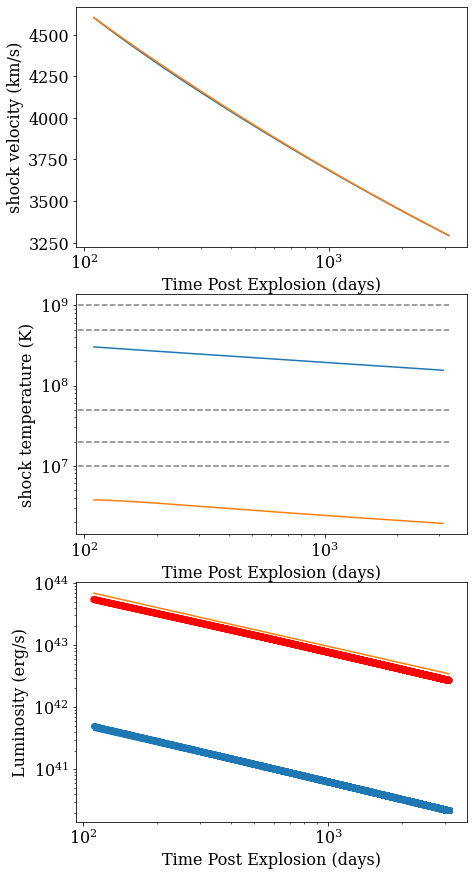

In [5]:
#constants:
msun = 1.989e+33 #grams
s_in_year = 3.154e+7
s_in_day = 86400.

#Customization for run related to integration:
time_start = 0.3 #year
step = 1/365 * s_in_year #year
niter = 3000

#Customization for run related to CSM profile:
Mdot_test = 1e-2
s_test = 2

# Set the initial conditions:
Rs_i,vs_i,ts_i = initial_conds_f96(time_start,Mdot=Mdot_test,s=s_test)
Tfs_i,Trs_i = shock_temp(vs_i,Rs_i/ts_i)

#Make arrays that we will append things on:
Rs_array = np.zeros(niter)
vs_array = np.zeros(niter)
ts_array = np.zeros(niter)
Tfs_array = np.zeros(niter)
Trs_array = np.zeros(niter)
Lfs_array = np.zeros(niter)
Lrs_array = np.zeros(niter)
color_plot = ['r']
Rs_array[0] = Rs_i
vs_array[0] = vs_i
ts_array[0] = ts_i
Tfs_array[0] = Tfs_i
Trs_array[0] = Trs_i


#Try a loop where I go through and do this integration:
for i in range(1,niter):
    #set the new time
    time_new = ts_array[i-1]+step
    time_new_year = time_new/s_in_year
    time_new_day = time_new/s_in_day
    ts_array[i] = time_new

    #use the previous velocity to advance the radius one time step:
    radius_new = Rs_array[i-1] + vs_array[i-1] * step
    Rs_array[i] = radius_new
    
    #calculate various physical parameters for the previous time step, which will be used to calculate dVdt.
    M_csm, M_ej, rho_csm, rho_ej, V = physical_params_rs_v1(Rs_array[i-1],ts_array[i-1]/s_in_year,Mdot=Mdot_test,s=s_test)
    #print('Params',M_csm/msun, M_ej/msun, rho_csm, rho_ej, V)
    
    #use these parameters and an RK4 to determine a new velocity.
    vs_new = RK4_eom_c03(ts_array[i-1],vs_array[i-1],step,Rs_array[i-1],M_csm,M_ej,rho_csm,rho_ej)
    vs_array[i] = vs_new
    
    #Physical parameters for this new time step/radius:
    M_csm2, M_ej2, rho_csm2, rho_ej2, V2 = physical_params_rs_v1(Rs_array[i],ts_array[i]/s_in_year,Mdot=Mdot_test,s=s_test)
    
    #Temperature at each of the shocks at this time point:
    Tfs, Trs = shock_temp(vs_new,V2)
    Tfs_array[i] = Tfs
    Trs_array[i] = Trs
    
    #calculate if adiabatic or radiative at this time step:
    ##To be added##
    tcool_rev,rad_rev,color_rev = tcool_N09(Trs,rho_ej2,time_new_day,comp='solar')
    color_plot.append(color_rev)
    #print(rad_rev)
    
    #Nh values from CSM and cold-dense shell:
    ##To be added##
    
    #Brehmstrahlung X-ray from each of the shocks at this new time step:
    L_fs = adiabatic_lum([M_csm2],[rho_csm2],[Tfs],gff='N06')
    L_rs = adiabatic_lum([M_ej2],[rho_ej2],[Tfs],gff='F96r')
    Lfs_array[i] = L_fs
    Lrs_array[i] = L_rs
    
    
    
## Make a summary plot of the velocity over time:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 16})
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
figure, subplots = plt.subplots(3, 1, figsize=(7,15))

#Plot the velocity came out of this:
subplots[0].plot(ts_array/s_in_day, vs_array/1e5)

#Plot the analytical velocity solution:
Rs_test,vs_test,ts_test = initial_conds_f96(ts_array/s_in_year,Mdot=Mdot_test,s=s_test)
subplots[0].plot(ts_test/s_in_day,vs_test/1e5)

#Plot the tempertatures of the shocks:
subplots[1].plot(ts_array/s_in_day,Tfs_array)
subplots[1].plot(ts_array/s_in_day,Trs_array)
#Add a few reference temps: 
subplots[1].hlines([1e9,5e8,5e7,2e7,1e7],0,9*365,linestyle='--',color='k',alpha=0.5)

#Plot the adiabatic luminosity for each shock:
#subplots[2].plot(ts_array[1:]/s_in_day,Lfs_array[1:])
#subplots[2].plot(ts_array[1:]/s_in_day,Lrs_array[1:])
subplots[2].scatter(ts_array[1:]/s_in_day,Lfs_array[1:])
subplots[2].scatter(ts_array[1:]/s_in_day,Lrs_array[1:],color=color_plot[1:])

#Plot the luminosities from my code up of Chevalier 06 equations for comparison.
lum_fs_c06 = fs_adiabatic_c06(ts_array[1:]/s_in_day,Mdot_test)
lum_rs_c06 = rs_adiabatic_c06(ts_array[1:]/s_in_day,Mdot_test)
subplots[2].plot(ts_array[1:]/s_in_day,lum_fs_c06)
subplots[2].plot(ts_array[1:]/s_in_day,lum_rs_c06)

#Plot axes labels
subplots[0].set_ylabel('shock velocity (km/s)')
subplots[0].set_xlabel('Time Post Explosion (days)')
subplots[1].set_ylabel('shock temperature (K)')
subplots[1].set_xlabel('Time Post Explosion (days)')
subplots[2].set_ylabel('Luminosity (erg/s)')
subplots[2].set_xlabel('Time Post Explosion (days)')
#subplots[2].set_legend()
subplots[1].set_yscale('log')
subplots[2].set_yscale('log')
subplots[0].set_xscale('log')
subplots[1].set_xscale('log')
subplots[2].set_xscale('log')
plt.show()

#Make a plot 

### Now try and see what it looks like varying the CSM profile:

<ipython-input-2-d469e49d6c50>:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if gff=='F96r':
<ipython-input-2-d469e49d6c50>:308: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if gff=='F96f':


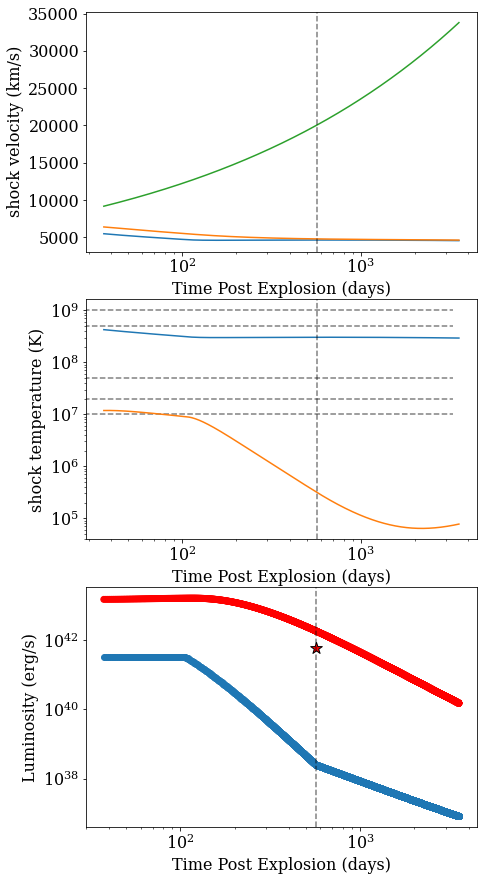

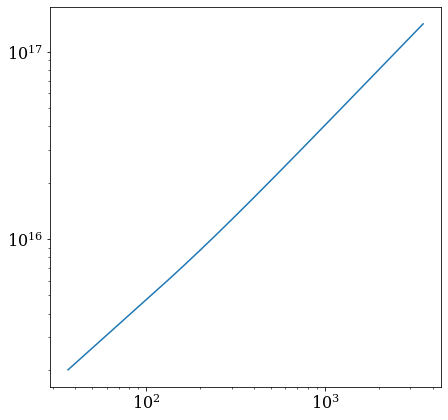

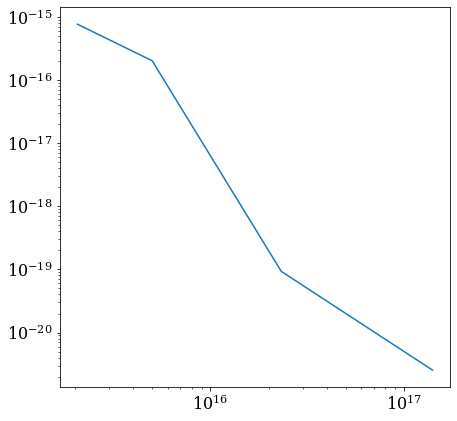

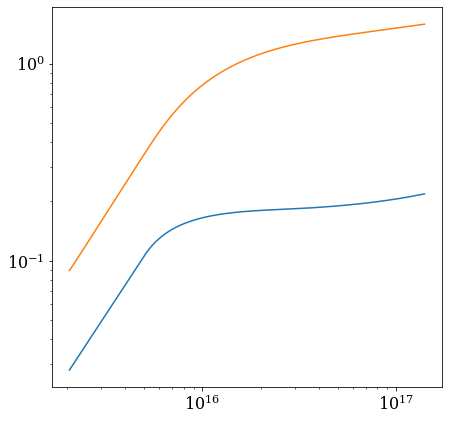

In [6]:
#constants:
msun = 1.989e+33 #grams
s_in_year = 3.154e+7
s_in_day = 86400.

#Customization for run related to integration:
time_start = 0.1 #year
step = 1/365 * s_in_year #year
niter = 3500

#Customization for run related to CSM profile:
Mdot1=1e-2
Mdot2=1e-4
s1=1.5
s2=5
s3=2
r0=5e15

Mdot_test = Mdot2
s_test = s2

# Set the initial conditions:
Rs_i,vs_i,ts_i = initial_conds_f96(time_start,Mdot=Mdot1,s=s1,r0=r0)
Tfs_i,Trs_i = shock_temp(vs_i,Rs_i/ts_i)

#Make arrays that we will append things on:
Rs_array = np.zeros(niter)
vs_array = np.zeros(niter)
ts_array = np.zeros(niter)
Tfs_array = np.zeros(niter)
Trs_array = np.zeros(niter)
Lfs_array = np.zeros(niter)
Lrs_array = np.zeros(niter)
rho_csm_array = np.zeros(niter)
rho_ej_array = np.zeros(niter)
M_csm_array = np.zeros(niter)
M_ej_array = np.zeros(niter)
color_plot = ['r']
Rs_array[0] = Rs_i
vs_array[0] = vs_i
ts_array[0] = ts_i
Tfs_array[0] = Tfs_i
Trs_array[0] = Trs_i


#Try a loop where I go through and do this integration:
for i in range(1,niter):
    #set the new time
    time_new = ts_array[i-1]+step
    time_new_year = time_new/s_in_year
    time_new_day = time_new/s_in_day
    ts_array[i] = time_new

    #use the previous velocity to advance the radius one time step:
    radius_new = Rs_array[i-1] + vs_array[i-1] * step
    Rs_array[i] = radius_new
    
    #calculate various physical parameters for the previous time step, which will be used to calculate dVdt.
    M_csm, M_ej, rho_csm, rho_ej, V = physical_params_rs_v2(Rs_array[i-1],ts_array[i-1]/s_in_year,Mdot1=Mdot1,Mdot2=Mdot2,s1=s1,s2=s2,s3=s3,r0=r0)
    #physical_params_rs_v2(Rs,time_calc,delta=2,n=12,E=1e51,M=10,t0=1,Mdot1=1e-3,Mdot2=1e-5,vw=100,r0=1e15,s1=1.5,s2=20,s3=2):
    
    #print('Params',M_csm/msun, M_ej/msun, rho_csm, rho_ej, V)
    
    #use these parameters and an RK4 to determine a new velocity.
    vs_new = RK4_eom_c03(ts_array[i-1],vs_array[i-1],step,Rs_array[i-1],M_csm,M_ej,rho_csm,rho_ej)
    vs_array[i] = vs_new
    
    #Physical parameters for this new time step/radius:
    M_csm2, M_ej2, rho_csm2, rho_ej2, V2 = physical_params_rs_v2(Rs_array[i],ts_array[i]/s_in_year,Mdot1=Mdot1,Mdot2=Mdot2,s1=s1,s2=s2,s3=s3,r0=r0)
    rho_csm_array[i] = rho_csm2
    rho_ej_array[i] = rho_ej2
    M_csm_array[i] = M_csm2
    M_ej_array[i] = M_ej2
    
    
    #Temperature at each of the shocks at this time point:
    Tfs, Trs = shock_temp(vs_new,V2)
    Tfs_array[i] = Tfs
    Trs_array[i] = Trs
    
    #calculate if adiabatic or radiative at this time step:
    ##To be added##
    tcool_rev,rad_rev,color_rev = tcool_N09(Trs,rho_ej2,time_new_day,comp='solar')
    color_plot.append(color_rev)
    #print(rad_rev)
    
    #Nh values from CSM and cold-dense shell:
    ##To be added##
    
    #Brehmstrahlung X-ray from each of the shocks at this new time step:
    L_fs = adiabatic_lum([M_csm2],[rho_csm2],[Tfs],gff='N06')
    L_rs = adiabatic_lum([M_ej2],[rho_ej2],[Tfs],gff='F96r')
    Lfs_array[i] = L_fs
    Lrs_array[i] = L_rs
    
    
    
## Make a summary plot of the velocity over time:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 16})
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
figure, subplots = plt.subplots(3, 1, figsize=(7,15))

#Plot the velocity came out of this:
subplots[0].plot(ts_array/s_in_day, vs_array/1e5)
subplots[0].plot(ts_array/s_in_day, Rs_array/ts_array/1e5)

#Plot the analytical velocity solution:
Rs_test,vs_test,ts_test = initial_conds_f96(ts_array/s_in_year,Mdot=Mdot_test,s=s_test,r0=r0)
subplots[0].plot(ts_test/s_in_day,vs_test/1e5)

#Plot the tempertatures of the shocks:
subplots[1].plot(ts_array/s_in_day,Tfs_array)
subplots[1].plot(ts_array/s_in_day,Trs_array)
#Add a few reference temps: 
subplots[1].hlines([1e9,5e8,5e7,2e7,1e7],0,9*365,linestyle='--',color='k',alpha=0.5)

#Plot the adiabatic luminosity for each shock:
#subplots[2].plot(ts_array[1:]/s_in_day,Lfs_array[1:])
#subplots[2].plot(ts_array[1:]/s_in_day,Lrs_array[1:])
subplots[2].scatter(ts_array[1:]/s_in_day,Lfs_array[1:])
subplots[2].scatter(ts_array[1:]/s_in_day,Lrs_array[1:],color=color_plot[1:])

#Plot the luminosities from my code up of Chevalier 06 equations for comparison.
#lum_fs_c06 = fs_adiabatic_c06(ts_array[1:]/s_in_day,Mdot_test)
#lum_rs_c06 = rs_adiabatic_c06(ts_array[1:]/s_in_day,Mdot_test)
#subplots[2].plot(ts_array[1:]/s_in_day,lum_fs_c06)
#subplots[2].plot(ts_array[1:]/s_in_day,lum_rs_c06)

#plot the value for PS1-11aop"
t_sn = 55770.562 - 5.5
t_obs =  56454.4
#z = 0.117
z = 0.218
t_phase = (t_obs - t_sn)/(1+z)
subplots[2].scatter([t_phase],[6e41],s=150,marker='*',color='red',edgecolor='k')

subplots[0].axvline(t_phase,color='k',linestyle='--',alpha=0.5)
subplots[1].axvline(t_phase,color='k',linestyle='--',alpha=0.5)
subplots[2].axvline(t_phase,color='k',linestyle='--',alpha=0.5)
#Plot axes labels
subplots[0].set_ylabel('shock velocity (km/s)')
subplots[0].set_xlabel('Time Post Explosion (days)')
subplots[1].set_ylabel('shock temperature (K)')
subplots[1].set_xlabel('Time Post Explosion (days)')
subplots[2].set_ylabel('Luminosity (erg/s)')
subplots[2].set_xlabel('Time Post Explosion (days)')
subplots[1].set_yscale('log')
subplots[2].set_yscale('log')
subplots[0].set_xscale('log')
subplots[1].set_xscale('log')
subplots[2].set_xscale('log')
plt.show()

#Make a plot of the radius vs. time

figure, subplots = plt.subplots(1, 1, figsize=(7,7))
subplots.plot(ts_array/s_in_day,Rs_array)
subplots.set_yscale('log')
subplots.set_xscale('log')
plt.show()

#Make a plot of the csm density vs. radius 

figure, subplots = plt.subplots(1, 1, figsize=(7,7))
subplots.plot(Rs_array[1:],rho_csm_array[1:])
subplots.set_yscale('log')
subplots.set_xscale('log')
plt.show()

#Make a plot of the mass swept up vs. radius

figure, subplots = plt.subplots(1, 1, figsize=(7,7))
subplots.plot(Rs_array[1:],M_csm_array[1:]/msun)
subplots.plot(Rs_array[1:],M_ej_array[1:]/msun)
subplots.set_yscale('log')
subplots.set_xscale('log')
plt.show()

## Make a Summary Plot that will show new model in comparison to the old one for a variety of Mdots (good for thesis document)

In [7]:
#constants:
msun = 1.989e+33 #grams
s_in_year = 3.154e+7
s_in_day = 86400.

#Customization for run related to integration:
time_start = 0.1 #year
step = 1/365 * s_in_year #year
niter = 3500

#################################################
#Customization for run related to CSM profile:
Mdot1=0.8e-2  #inner shell
Mdot2=1e-4 #outer region
s1=1.5 #inner region
s2=8 #steep fall betweeen regions
s3=2 #outer region
r0=5e15 #transition radius
#################################################

# Set the initial conditions:
Rs_i,vs_i,ts_i = initial_conds_f96(time_start,Mdot=Mdot1,s=s1,r0=r0)
Tfs_i,Trs_i = shock_temp(vs_i,Rs_i/ts_i)

#Make arrays that we will append things on:
Rs_array = np.zeros(niter)
vs_array = np.zeros(niter)
ts_array = np.zeros(niter)
Tfs_array = np.zeros(niter)
Trs_array = np.zeros(niter)
Lfs_array = np.zeros(niter)
Lrs_array = np.zeros(niter)
rho_csm_array = np.zeros(niter)
rho_ej_array = np.zeros(niter)
M_csm_array = np.zeros(niter)
M_ej_array = np.zeros(niter)
color_plot = ['r']
Rs_array[0] = Rs_i
vs_array[0] = vs_i
ts_array[0] = ts_i
Tfs_array[0] = Tfs_i
Trs_array[0] = Trs_i


#Try a loop where I go through and do this integration:
for i in range(1,niter):
    #set the new time
    time_new = ts_array[i-1]+step
    time_new_year = time_new/s_in_year
    time_new_day = time_new/s_in_day
    ts_array[i] = time_new

    #use the previous velocity to advance the radius one time step:
    radius_new = Rs_array[i-1] + vs_array[i-1] * step
    Rs_array[i] = radius_new
    
    #calculate various physical parameters for the previous time step, which will be used to calculate dVdt.
    M_csm, M_ej, rho_csm, rho_ej, V = physical_params_rs_v2(Rs_array[i-1],ts_array[i-1]/s_in_year,Mdot1=Mdot1,Mdot2=Mdot2,s1=s1,s2=s2,s3=s3,r0=r0)
    #physical_params_rs_v2(Rs,time_calc,delta=2,n=12,E=1e51,M=10,t0=1,Mdot1=1e-3,Mdot2=1e-5,vw=100,r0=1e15,s1=1.5,s2=20,s3=2):
    
    #print('Params',M_csm/msun, M_ej/msun, rho_csm, rho_ej, V)
    
    #use these parameters and an RK4 to determine a new velocity.
    vs_new = RK4_eom_c03(ts_array[i-1],vs_array[i-1],step,Rs_array[i-1],M_csm,M_ej,rho_csm,rho_ej)
    vs_array[i] = vs_new
    
    #Physical parameters for this new time step/radius:
    M_csm2, M_ej2, rho_csm2, rho_ej2, V2 = physical_params_rs_v2(Rs_array[i],ts_array[i]/s_in_year,Mdot1=Mdot1,Mdot2=Mdot2,s1=s1,s2=s2,s3=s3,r0=r0)
    rho_csm_array[i] = rho_csm2
    rho_ej_array[i] = rho_ej2
    M_csm_array[i] = M_csm2
    M_ej_array[i] = M_ej2
    
    
    #Temperature at each of the shocks at this time point:
    Tfs, Trs = shock_temp(vs_new,V2)
    Tfs_array[i] = Tfs
    Trs_array[i] = Trs
    
    #calculate if adiabatic or radiative at this time step:
    ##To be added##
    tcool_rev,rad_rev,color_rev = tcool_N09(Trs,rho_ej2,time_new_day,comp='solar')
    color_plot.append(color_rev)
    #print(rad_rev)
    
    #Nh values from CSM and cold-dense shell:
    ##To be added##
    
    #Brehmstrahlung X-ray from each of the shocks at this new time step:
    L_fs = adiabatic_lum([M_csm2],[rho_csm2],[Tfs],gff='N06')
    L_rs = adiabatic_lum([M_ej2],[rho_ej2],[Tfs],gff='F96r')
    Lfs_array[i] = L_fs
    Lrs_array[i] = L_rs
    
    


<ipython-input-2-d469e49d6c50>:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if gff=='F96r':
<ipython-input-2-d469e49d6c50>:308: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if gff=='F96f':


In [8]:
# Comparison Type IIn SNe
import numpy as np
compdata = np.loadtxt('IIncomparison.txt',delimiter="\t",skiprows=1)


shock velocity was: [15211.59821099 15171.61801061 15132.76413109 ...  9655.11526677
  9654.8420642   9654.56894665]  reverse shock temperature is (10^8 K):  [0.32222431 0.32053275 0.31889311 ... 0.1298146  0.12980725 0.12979991]
shock velocity was: [12083.00195427 12051.24455228 12020.38181875 ...  7669.33066591
  7669.1136534   7668.89670841]  reverse shock temperature is (10^8 K):  [0.2033098  0.20224249 0.20120795 ... 0.08190748 0.08190284 0.08189821]
shock velocity was: [9597.8696125  9572.64381145 9548.1286708  ... 6091.96588937 6091.7935102
 6091.62118468]  reverse shock temperature is (10^8 K):  [0.12827981 0.12760639 0.12695364 ... 0.05168012 0.0516772  0.05167427]
1645.556650246306
6.936301056132856e+16


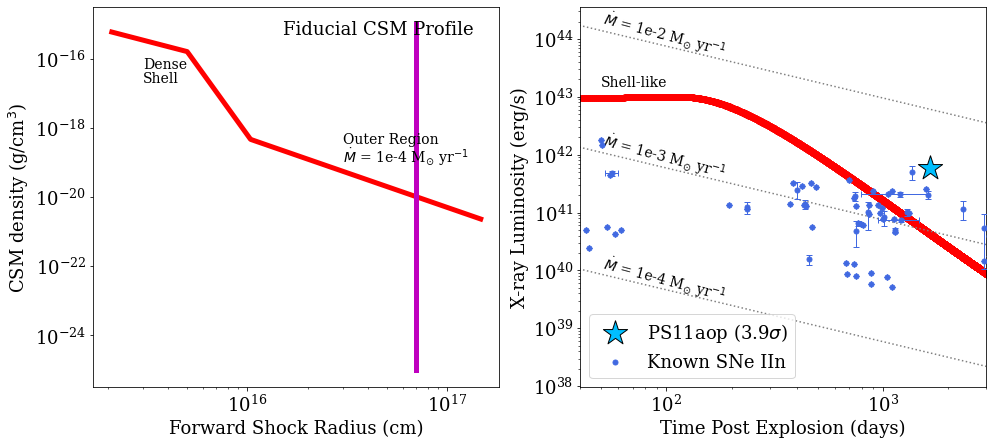

In [9]:
    
## Make a summary plot of the velocity over time:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 18})
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
figure, subplots = plt.subplots(1, 2, figsize=(16,7))


#Plot the adiabatic luminosity for the reverse shock:
subplots[1].scatter((ts_array[1:]/s_in_day),Lrs_array[1:],color='red')

#Plot the luminosities from my code up of Chevalier 06 equations for comparison.
lum_rs_c06 = rs_adiabatic_c06(ts_array[1:]/s_in_day,1e-4)
subplots[1].plot((ts_array[1:]/s_in_day),lum_rs_c06,linestyle='dotted',color='grey')

lum_rs_c06 = rs_adiabatic_c06(ts_array[1:]/s_in_day,1e-3)
subplots[1].plot((ts_array[1:]/s_in_day),lum_rs_c06,linestyle='dotted',color='grey')

lum_rs_c06 = rs_adiabatic_c06(ts_array[1:]/s_in_day,1e-2)
subplots[1].plot((ts_array[1:]/s_in_day),lum_rs_c06,linestyle='dotted',color='grey')

#plot the value for PS1-11aop"
t_sn = 55770.562 - 5.5
t_obs =  57769.35 #56454.4
z = 0.218
t_phase = (t_obs - t_sn)/(1+z)
subplots[1].scatter([t_phase],[6e41],s=650,marker='*',color='deepskyblue',edgecolor='k',label='PS11aop (3.9$\sigma$)')
print(t_phase) #in days
aop_radius = np.interp(t_phase*86400.,ts_array,Rs_array)
print(aop_radius)


#Make CSM Density vs. Radius:
subplots[0].plot(Rs_array[1:],rho_csm_array[1:],color='red',linewidth=5)
subplots[0].plot([aop_radius,aop_radius],[1e-25,1e-15],color='m',linewidth=5)

# Plot IIn comparison data
subplots[1].scatter(compdata[:,0],compdata[:,2],zorder=8,linestyle='None',marker='.', c='royalblue',s=100, label='Known SNe IIn')
subplots[1].errorbar(compdata[:,0],compdata[:,2],xerr=compdata[:,1],yerr=compdata[:,3],zorder=7,elinewidth=1,ecolor='royalblue',capsize=3,linestyle='None',marker="")
subplots[1].set_xlim(40,3000)


#subplots[1].axvline(t_phase,color='k',linestyle='--',alpha=0.5)

#Plot axes labels
subplots[1].set_ylabel('X-ray Luminosity (erg/s)')
subplots[1].set_xlabel('Time Post Explosion (days)')
subplots[0].set_ylabel(r'CSM density (g/cm$^3$)')
subplots[0].set_xlabel('Forward Shock Radius (cm)')
subplots[0].set_yscale('log')
subplots[1].set_yscale('log')
subplots[0].set_xscale('log')
subplots[1].set_xscale('log')


###Add text Lablels###

subplots[1].text(50,3e39,r'$\.M$ = 1e-4 M$_{\odot}$ yr$^{-1}$',fontsize=14,rotation=-15)
subplots[1].text(50,4e41,r'$\.M$ = 1e-3 M$_{\odot}$ yr$^{-1}$',fontsize=14,rotation=-15)
subplots[1].text(50,5e43,r'$\.M$ = 1e-2 M$_{\odot}$ yr$^{-1}$',fontsize=14,rotation=-15)
subplots[1].text(50,1.5e43,r'Shell-like',fontsize=14)
subplots[1].legend()

subplots[0].text(1.5e16,5e-16,r'Fiducial CSM Profile')
subplots[0].text(3e16,3.5e-19,r'Outer Region',fontsize=14)
subplots[0].text(3e16,1e-19,r'$\.M$ = 1e-4 M$_{\odot}$ yr$^{-1}$',fontsize=14)
subplots[0].text(3e15,5.1e-17,r'Dense',fontsize=14)
subplots[0].text(3e15,2e-17,r'Shell',fontsize=14)
plt.savefig('Xray_Example.pdf')
plt.show()



shock velocity was: [15211.59821099 15171.61801061 15132.76413109 ...  9655.11526677
  9654.8420642   9654.56894665]  reverse shock temperature is (10^8 K):  [0.32222431 0.32053275 0.31889311 ... 0.1298146  0.12980725 0.12979991]
shock velocity was: [12083.00195427 12051.24455228 12020.38181875 ...  7669.33066591
  7669.1136534   7668.89670841]  reverse shock temperature is (10^8 K):  [0.2033098  0.20224249 0.20120795 ... 0.08190748 0.08190284 0.08189821]
shock velocity was: [9597.8696125  9572.64381145 9548.1286708  ... 6091.96588937 6091.7935102
 6091.62118468]  reverse shock temperature is (10^8 K):  [0.12827981 0.12760639 0.12695364 ... 0.05168012 0.0516772  0.05167427]


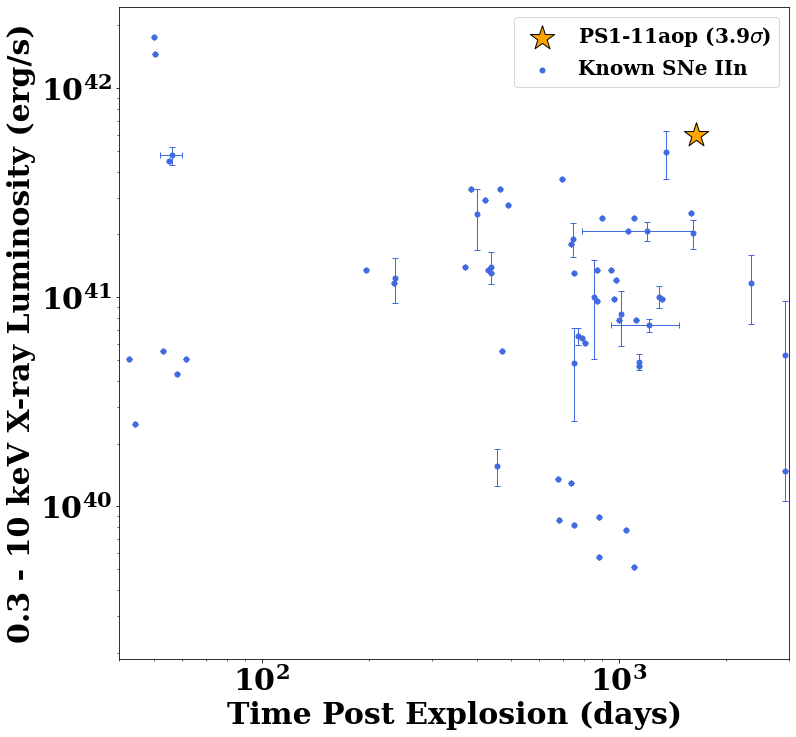

In [10]:
figure= plt.figure(figsize=(12,12))
from matplotlib import rc,rcParams
rc('font', weight='bold')
#fig = plt.figure(figsize=(12,12))
#Plot the luminosities from my code up of Chevalier 06 equations for comparison.
lum_rs_c06 = rs_adiabatic_c06(ts_array[1:]/s_in_day,1e-4)
#plt.plot((ts_array[1:]/s_in_day),lum_rs_c06,linestyle='dotted',color='grey')

lum_rs_c06 = rs_adiabatic_c06(ts_array[1:]/s_in_day,1e-3)
#plt.plot((ts_array[1:]/s_in_day),lum_rs_c06,linestyle='dotted',color='grey')

lum_rs_c06 = rs_adiabatic_c06(ts_array[1:]/s_in_day,1e-2)
#plt.plot((ts_array[1:]/s_in_day),lum_rs_c06,linestyle='dotted',color='grey')

#plot the value for PS1-11aop"
t_sn = 55770.562# - 5.5
t_obs =  57769.35 # #X-ray observation date  57769.35
z = 0.218

t_phase = (t_obs - t_sn)/(1+z)
#plt.scatter([t_phase],[6e41],s=650,marker='*',color='orange',edgecolor='k',label='PS1-11aop (3.9$\sigma$)') #color='deepskyblue'
plt.scatter([t_phase],[6e41],s=650,marker='*',color='orange',edgecolor='k',label='PS1-11aop') 
# Plot IIn comparison data
plt.scatter(compdata[:,0],compdata[:,2],zorder=8,linestyle='None',marker='.', c='royalblue',s=100, label='Known SNe IIn')
plt.errorbar(compdata[:,0],compdata[:,2],xerr=compdata[:,1],yerr=compdata[:,3],zorder=7,elinewidth=1,ecolor='royalblue',capsize=3,linestyle='None',marker="")
plt.xlim(40,3000)


#Plot axes labels
plt.ylabel('0.3 - 10 keV X-ray Luminosity (erg/s)',fontsize=30,fontweight='bold')
plt.xlabel('Time Post Explosion (days)',fontsize=30,fontweight='bold')
plt.yscale('log')
plt.xscale('log')

###Add text Lablels###

#plt.text(50,3e39,r'$\.M$ = 1e-4 M$_{\odot}$ yr$^{-1}$',fontsize=25,rotation=-15)
#plt.text(50,4e41,r'$\.M$ = 1e-3 M$_{\odot}$ yr$^{-1}$',fontsize=25,rotation=-15)
#plt.text(50,5e43,r'$\.M$ = 1e-2 M$_{\odot}$ yr$^{-1}$',fontsize=25,rotation=-15)
#plt.text(50,1.5e43,r'Shell-like',fontsize=25)
plt.legend(fontsize=20)
plt.tick_params(labelsize = 30)
#figure.savefig('x-ray-result.png',dpi = 300,transparent=True,bbox_inches='tight')


In [16]:
import numpy as np
#SN1978K_lc_30_1000.txt (0.3-10; 0.5-2; 2-10)
time=[10188.9707031,10783.6455078,11474.6113281]
errtime=[69.0148010,6.0209608,60.5016708]

flux = np.array([1.1125000193715096e+03,1.1034999974071980e+03,9.8000001162290562e+02])*1e-15 #erg/s/cm2
fluxerr=np.array([9.5000003415106335e+01,8.5000000202457841e+01,4.2999996873729557e+01])*1e-15 #erg/s/cm2
ld= 4.13 #Mpc
zred=0.00156
lum = 4*np.pi*flux*(ld*3.08*1e24)**2/(1+zred)
lum

array([2.25857468e+39, 2.24030303e+39, 1.98957589e+39])

In [17]:
#SN1995N_lc_20_1000.txt (0.1-2.4; 0.2-10; 0.5-7)
time=[750,770,1140,1296,3310,3554]
errtime=[0,0,0,0,0,0]

flux = np.array([719,973,734,1502,173,117])*1e-15 #erg/s/cm2
fluxerr=np.array([340,95,64,185,27,27])*1e-15 #erg/s/cm2
ld= 24 #Mpc
zred=0.006191
lum = 4*np.pi*flux*(ld*3.08*1e24)**2/(1+zred)
lum

array([4.90661794e+40, 6.63997115e+40, 5.00898132e+40, 1.02499863e+41,
       1.18059096e+40, 7.98434352e+39])

In [18]:
#SN1996cr_lc_30_1000.txt (0.3-10; 0.5-2; 0.5-8; 2-8)
time=[4405.6250000,4828.1425781,5374.3500977]
errtime=[0.3671875,0.5683594,0.6045370]

flux = np.array([6.1349999159574509e+03,6.9300003349781027e+03,6.4000003039836884e+03])*1e-15 #erg/s/cm2
fluxerr=np.array([2.3000000e+02,2.7500000e+02,2.7999997e+02])*1e-15 #erg/s/cm2
ld= 3.7 #Mpc
zred=0.001448
lum = 4*np.pi*flux*(ld*3.08*1e24)**2/(1+zred)
lum

array([9.99771846e+39, 1.12932670e+40, 1.04295684e+40])

In [19]:
#SN2002hi_lc_50_1000.txt (0.5-10)
time=[50]
errtime=[0]

flux = np.array([193])*1e-15 #erg/s/cm2
fluxerr=np.array([0])*1e-15 #erg/s/cm2
ld= 269.9 #Mpc
zred=0.061
lum = 4*np.pi*flux*(ld*3.08*1e24)**2/(1+zred)
lum

array([1.57964316e+42])

In [33]:
#SN2005ip_lc_20_1000.txt: (0.2-10)

#I dont understand what these are but there were contained in the same file as the unaborbed flux
#time=[456,1213.1420898 ]
#errtime=[0.4304572,262.0863037]
#flux = np.array([150,7.0000002160668373e+02])*1e-15 #erg/s/cm2
#fluxerr=np.array([30,5.0000004e+01])*1e-15 #erg/s/cm2

#unabsorbed fluxes
time=[474.9,798.09,1115.87,1483.53,2339.12]
errtime=[0,0,0,0,5]
flux = np.array([569,600,811,780,446])*1e-15 #erg/s/cm2
fluxerr=np.array([150,100.,150,170,100])*1e-15 #erg/s/cm2
ld= 30 #Mpc
zred=0.007138
lum = 4*np.pi*flux*(ld*3.08*1e24)**2/(1+zred)
lum

array([6.06145786e+40, 6.39169546e+40, 8.63944170e+40, 8.30920410e+40,
       4.75116029e+40])

In [21]:
#SN2005kd_lc_20_1000.txt (0.2-10;0.5-8)
time=[438.,1013.6763916]
errtime=[0,0.271493]

flux = np.array([290,171.768])*1e-15 #erg/s/cm2
fluxerr=np.array([50,50])*1e-15 #erg/s/cm2
ld= 64.3 #Mpc
zred=0.015040
lum = 4*np.pi*flux*(ld*3.08*1e24)**2/(1+zred)
lum

array([1.40814729e+41, 8.34050496e+40])

In [34]:
#SN2006jd_lc_20_1000.txt: (0.2-10)

#I dont understand what these are but there were contained in the same file as the unaborbed flux
#time=[400,1200.7727051,1610.4080811]
#errtime=[0,411.7231445,2.0877488]
#flux = np.array([340,2.8295000083744526e+02,2.7534998953342438e+02])*1e-15 #erg/s/cm2
#fluxerr=np.array([110,2.9000000e+01,4.4500000e+01])*1e-15 #erg/s/cm2

#unabsorbed fluxes
time=[403.2,431.5,459.8,496.2,698.5,907.7,1063.6,1067.5,1609.8]
errtime=[3.1,0,0,0.6,1.0,0,0,0,2]
flux = np.array([451.,428,491,398,535,363,301,338,371])*1e-15 #erg/s/cm2
fluxerr=np.array([73,73,79,66,73,30,60,90,60])*1e-15 #erg/s/cm2

ld= 79.5 #Mpc
zred=0.018556
lum = 4*np.pi*flux*(ld*3.08*1e24)**2/(1+zred)
lum

array([3.33608559e+41, 3.16595263e+41, 3.63196902e+41, 2.94404006e+41,
       3.95744078e+41, 2.68514206e+41, 2.22652276e+41, 2.50021492e+41,
       2.74431875e+41])

In [24]:
#SN2007pk_lc_20_1000.txt (0.2-10)
time=[4.5,55.9843750,236.3710938 ,745.6679688 ,852.6621094]
errtime=[2,3.9570312,0.3671875,0.2695312,0.2363281]

flux = np.array([290,8.0700004473328590e+02,2.1035000681877136e+02,3.2254999969154596e+02,1.7010000301524994e+02])*1e-15 #erg/s/cm2
fluxerr=np.array([50,8.0000000e+01,5.0000004e+01,6.0000008e+01,8.5000000e+01])*1e-15 #erg/s/cm2
ld= 71.3 #Mpc
zred=0.016655
lum = 4*np.pi*flux*(ld*3.08*1e24)**2/(1+zred)
lum


array([1.72868058e+41, 4.81050106e+41, 1.25388956e+41, 1.92271007e+41,
       1.01396059e+41])

In [26]:
#SN2010jl_lc_20_1000.txt
time=np.array([5505.085,5511.216,5521.480,5523.825,5533.896,5537.528,5540.802,5675.205,5850.136,6217.453,6325.680,6379.881,6429.259])-5479
lum = np.array([0.486,0.438,0.528,0.286,0.588,0.449,0.540,1.364,1.465,1.404,1.402,1.380,1.319])*1e41 #erg/s/cm2
lum


array([4.860e+40, 4.380e+40, 5.280e+40, 2.860e+40, 5.880e+40, 4.490e+40,
       5.400e+40, 1.364e+41, 1.465e+41, 1.404e+41, 1.402e+41, 1.380e+41,
       1.319e+41])

In [ ]:
#SN2001em (Ibc --> IIn ish)
time=[935.]
lum=[1e41]

In [29]:
#SN1986J_lc_20_1000.txt
time=np.array([48486.1,49206.5,49374.5,49744.0,50113.5,51852.0,52508.0])-45349
flux=np.array([790,491,607,395,528,96,85])*1e-15 #erg/s/cm2
fluxerr=np.array([41.,24.,13,26,10.,5.,15.])*1e-15 #erg/s/cm2
ld= 12 #Mpc
lum = 4*np.pi*flux*(ld*3.08*1e24)**2#/(1+zred)
lum

array([1.35612862e+40, 8.42859684e+39, 1.04198743e+40, 6.78064308e+39,
       9.06374569e+39, 1.64795376e+39, 1.45912573e+39])

In [31]:
#SN1988Z_lc_20_200.txt
time=np.array([2335,2924.,3085,5678])
lum=np.array([3.4,1.5,1.15,0.27])*1e40
lum

array([3.40e+40, 1.50e+40, 1.15e+40, 2.70e+39])

In [32]:
#SN1998S_lc_02_1000.txt
time=np.array([678,735.,882,1048.])
lum=np.array([9.3,8.8,6.1,5.3])*1e39
lum

array([9.3e+39, 8.8e+39, 6.1e+39, 5.3e+39])

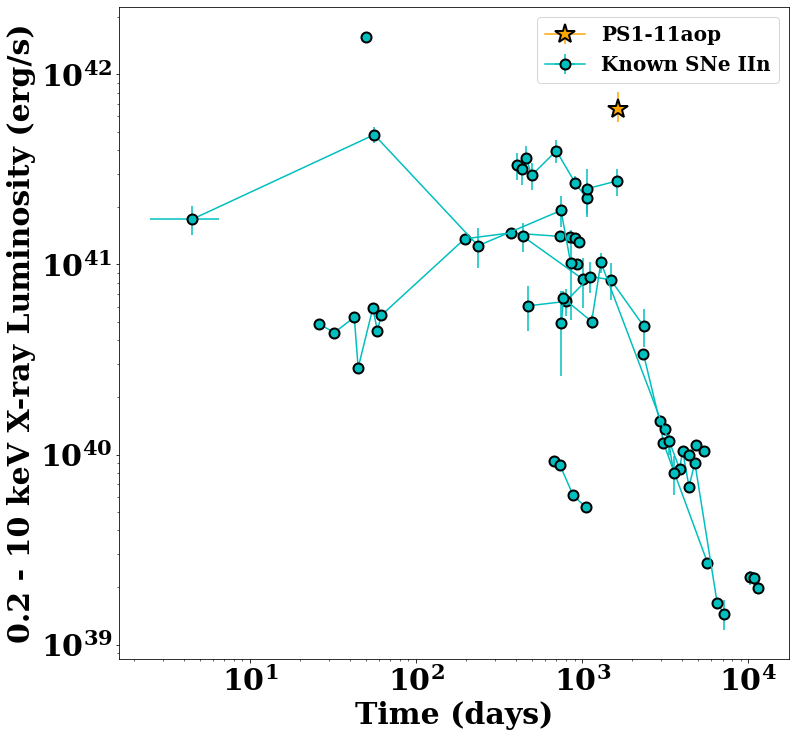

In [75]:
figure= plt.figure(figsize=(12,12))
from matplotlib import rc,rcParams
rc('font', weight='bold')
#fig = plt.figure(figsize=(12,12))

#plot the value for PS1-11aop"
t_sn = 55770.562# - 5
t_obs =  57769.35 # #X-ray observation date  57769.35
z = 0.218

t_phase = (t_obs - t_sn)/(1+z)
#plt.scatter([t_phase],[6e41],s=650,marker='*',color='orange',edgecolor='k',label='PS1-11aop (3.9$\sigma$)') #color='deepskyblue' 
lower_error =  1e41
upper_error =  1.5*1e41
asymmetric_error = np.array([[lower_error, upper_error]]).T
plt.errorbar([t_phase],[6.6e41],yerr= asymmetric_error, marker='*',color='orange',markersize=20,markeredgecolor='k',markeredgewidth=2,label='PS1-11aop')

# Plot IIn comparison data
#SN1998S_lc_02_1000.txt
time_a=np.array([678,735.,882,1048.])
lum_a=np.array([9.3,8.8,6.1,5.3])*1e39
plt.plot(time_a,lum_a,'co-', markersize=10,markeredgecolor='k',markeredgewidth=2)

#SN1988Z_lc_20_200.txt
time_b=np.array([2335,2924.,3085,5678])
lum_b=np.array([3.4,1.5,1.15,0.27])*1e40
plt.plot(time_b,lum_b,'co-', markersize=10,markeredgecolor='k',markeredgewidth=2)

#SN1986J_lc_20_1000.txt
time_c=np.array([48486.1,49206.5,49374.5,49744.0,50113.5,51852.0,52508.0])-45349
flux_c=np.array([790,491,607,395,528,96,85])*1e-15 #erg/s/cm2
fluxerr_c=np.array([41.,24.,13,26,10.,5.,15.])*1e-15 #erg/s/cm2
ld_c= 12 #Mpc
lum_c = 4*np.pi*flux_c*(ld_c*3.08*1e24)**2#/(1+zred)
lumerr_c = lum_c*(fluxerr_c/flux_c)
plt.errorbar(time_c,lum_c,yerr=lumerr_c,fmt='co-', markersize=10,markeredgecolor='k',markeredgewidth=2)

#SN2001em (Ibc --> IIn ish)
time_d=[935.]
lum_d=[1e41]
plt.plot(time_d,lum_d,'co-', markersize=10,markeredgecolor='k',markeredgewidth=2)

#SN2010jl_lc_20_1000.txt
time_e=np.array([5505.085,5511.216,5521.480,5523.825,5533.896,5537.528,5540.802,5675.205,5850.136,6217.453,6325.680,6379.881,6429.259])-5479
lum_e = np.array([0.486,0.438,0.528,0.286,0.588,0.449,0.540,1.364,1.465,1.404,1.402,1.380,1.319])*1e41 #erg/s/cm2
plt.plot(time_e,lum_e,'co-', markersize=10,markeredgecolor='k',markeredgewidth=2)

#SN2007pk_lc_20_1000.txt (0.2-10)
time_1=[4.5,55.9843750,236.3710938 ,745.6679688 ,852.6621094]
errtime_1=[2,3.9570312,0.3671875,0.2695312,0.2363281]
flux_1 = np.array([290,8.0700004473328590e+02,2.1035000681877136e+02,3.2254999969154596e+02,1.7010000301524994e+02])*1e-15 #erg/s/cm2
fluxerr_1=np.array([50,8.0000000e+01,5.0000004e+01,6.0000008e+01,8.5000000e+01])*1e-15 #erg/s/cm2
ld_1= 71.3 #Mpc
zred_1=0.016655
lum_1 = 4*np.pi*flux_1*(ld_1*3.08*1e24)**2/(1+zred_1)
lumerr_1=lum_1*(fluxerr_1/flux_1)
plt.errorbar(time_1,lum_1,yerr=lumerr_1,xerr=errtime_1,fmt='co-', markersize=10,markeredgecolor='k',markeredgewidth=2)

#SN2006jd_lc_20_1000.txt: (0.2-10)
#I dont understand what these are but there were contained in the same file as the unaborbed flux
#time=[400,1200.7727051,1610.4080811]
#errtime=[0,411.7231445,2.0877488]
#flux = np.array([340,2.8295000083744526e+02,2.7534998953342438e+02])*1e-15 #erg/s/cm2
#fluxerr=np.array([110,2.9000000e+01,4.4500000e+01])*1e-15 #erg/s/cm2
#unabsorbed fluxes
time_2=[403.2,431.5,459.8,496.2,698.5,907.7,1063.6,1067.5,1609.8]
errtime_2=[3.1,0,0,0.6,1.0,0,0,0,2]
flux_2 = np.array([451.,428,491,398,535,363,301,338,371])*1e-15 #erg/s/cm2
fluxerr_2=np.array([73,73,79,66,73,30,60,90,60])*1e-15 #erg/s/cm2
ld_2= 79.5 #Mpc
zred_2=0.018556
lum_2 = 4*np.pi*flux_2*(ld_2*3.08*1e24)**2/(1+zred_2)
lumerr_2=lum_2*(fluxerr_2/flux_2)
plt.errorbar(time_2,lum_2,yerr=lumerr_2,xerr=errtime_2,fmt='co-', markersize=10,markeredgecolor='k',markeredgewidth=2)

#SN2005kd_lc_20_1000.txt (0.2-10;0.5-8)
time_3=[438.,1013.6763916]
errtime_3=[0,0.271493]
flux_3 = np.array([290,171.768])*1e-15 #erg/s/cm2
fluxerr_3=np.array([50,50])*1e-15 #erg/s/cm2
ld_3= 64.3 #Mpc
zred_3=0.015040
lum_3 = 4*np.pi*flux_3*(ld_3*3.08*1e24)**2/(1+zred_3)
lumerr_3=lum_3*(fluxerr_3/flux_3)
plt.errorbar(time_3,lum_3,yerr=lumerr_3,xerr=errtime_3,fmt='co-', markersize=10,markeredgecolor='k',markeredgewidth=2)

#SN2005ip_lc_20_1000.txt: (0.2-10)
#I dont understand what these are but there were contained in the same file as the unaborbed flux
#time=[456,1213.1420898 ]
#errtime=[0.4304572,262.0863037]
#flux = np.array([150,7.0000002160668373e+02])*1e-15 #erg/s/cm2
#fluxerr=np.array([30,5.0000004e+01])*1e-15 #erg/s/cm2
#unabsorbed fluxes
time_4=[474.9,798.09,1115.87,1483.53,2339.12]
errtime_4=[0,0,0,0,5]
flux_4 = np.array([569,600,811,780,446])*1e-15 #erg/s/cm2
fluxerr_4=np.array([150,100.,150,170,100])*1e-15 #erg/s/cm2
ld_4= 30 #Mpc
zred_4=0.007138
lum_4 = 4*np.pi*flux_4*(ld_4*3.08*1e24)**2/(1+zred_4)
lumerr_4=lum_4*(fluxerr_4/flux_4)
plt.errorbar(time_4,lum_4,yerr=lumerr_4,xerr=errtime_4,fmt='co-', markersize=10,markeredgecolor='k',markeredgewidth=2)

#SN2002hi_lc_50_1000.txt (0.5-10)
time_5=[50]
errtime_5=[0]
flux_5 = np.array([193])*1e-15 #erg/s/cm2
fluxerr_5=np.array([0])*1e-15 #erg/s/cm2
ld_5= 269.9 #Mpc
zred_5=0.061
lum_5 = 4*np.pi*flux_5*(ld_5*3.08*1e24)**2/(1+zred_5)
lumerr_5=lum_5*(fluxerr_5/flux_5)
plt.errorbar(time_5,lum_5,yerr=lumerr_5,xerr=errtime_5,fmt='co-', markersize=10,markeredgecolor='k',markeredgewidth=2)

#SN1996cr_lc_30_1000.txt (0.3-10; 0.5-2; 0.5-8; 2-8)
time_6=[4405.6250000,4828.1425781,5374.3500977]
errtime_6=[0.3671875,0.5683594,0.6045370]
flux_6 = np.array([6.1349999159574509e+03,6.9300003349781027e+03,6.4000003039836884e+03])*1e-15 #erg/s/cm2
fluxerr_6=np.array([2.3000000e+02,2.7500000e+02,2.7999997e+02])*1e-15 #erg/s/cm2
ld_6= 3.7 #Mpc
zred_6=0.001448
lum_6 = 4*np.pi*flux_6*(ld_6*3.08*1e24)**2/(1+zred_6)
lumerr_6=lum_6*(fluxerr_6/flux_6)
plt.errorbar(time_6,lum_6,yerr=lumerr_6,xerr=errtime_6,fmt='co-', markersize=10,markeredgecolor='k',markeredgewidth=2)

#SN1995N_lc_20_1000.txt (0.1-2.4; 0.2-10; 0.5-7)
time_7=[750,770,1140,1296,3310,3554]
errtime_7=[0,0,0,0,0,0]
flux_7 = np.array([719,973,734,1502,173,117])*1e-15 #erg/s/cm2
fluxerr_7=np.array([340,95,64,185,27,27])*1e-15 #erg/s/cm2
ld_7= 24 #Mpc
zred_7=0.006191
lum_7 = 4*np.pi*flux_7*(ld_7*3.08*1e24)**2/(1+zred_7)
lumerr_7=lum_7*(fluxerr_7/flux_7)
plt.errorbar(time_7,lum_7,yerr=lumerr_7,xerr=errtime_7,fmt='co-', markersize=10,markeredgecolor='k',markeredgewidth=2)

#SN1978K_lc_30_1000.txt (0.3-10; 0.5-2; 2-10)
time_8=[10188.9707031,10783.6455078,11474.6113281]
errtime_8=[69.0148010,6.0209608,60.5016708]
flux_8 = np.array([1.1125000193715096e+03,1.1034999974071980e+03,9.8000001162290562e+02])*1e-15 #erg/s/cm2
fluxerr_8=np.array([9.5000003415106335e+01,8.5000000202457841e+01,4.2999996873729557e+01])*1e-15 #erg/s/cm2
ld_8= 4.13 #Mpc
zred_8=0.00156
lum_8 = 4*np.pi*flux_8*(ld_8*3.08*1e24)**2/(1+zred_8)
lumerr_8=lum_8*(fluxerr_8/flux_8)
plt.errorbar(time_8,lum_8,yerr=lumerr_8,xerr=errtime_8,fmt='co-', markersize=10,markeredgecolor='k',markeredgewidth=2,label='Known SNe IIn')

#plt.scatter(compdata[:,0],compdata[:,2],zorder=8,linestyle='None',marker='.', c='royalblue',s=100, label='Known SNe IIn')
#plt.errorbar(compdata[:,0],compdata[:,2],xerr=compdata[:,1],yerr=compdata[:,3],zorder=7,elinewidth=1,ecolor='royalblue',capsize=3,linestyle='None',marker="")
#plt.xlim(40,3000)


#Plot axes labels
plt.ylabel('0.2 - 10 keV X-ray Luminosity (erg/s)',fontsize=30,fontweight='bold')
plt.xlabel('Time (days)',fontsize=30,fontweight='bold')
plt.yscale('log')
plt.xscale('log')

###Add text Lablels###

#plt.text(50,3e39,r'$\.M$ = 1e-4 M$_{\odot}$ yr$^{-1}$',fontsize=25,rotation=-15)
#plt.text(50,4e41,r'$\.M$ = 1e-3 M$_{\odot}$ yr$^{-1}$',fontsize=25,rotation=-15)
#plt.text(50,5e43,r'$\.M$ = 1e-2 M$_{\odot}$ yr$^{-1}$',fontsize=25,rotation=-15)
#plt.text(50,1.5e43,r'Shell-like',fontsize=25)
plt.legend(fontsize=20)
plt.tick_params(labelsize = 30)
figure.savefig('x-ray-result.png',dpi = 300,transparent=True,bbox_inches='tight')
